In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import plotly.graph_objects as go
import plotly.express as px


In [2]:
processed_df = pd.read_pickle("data/processed_recipes.pkl")
processed_df

,name,ingredients,description,instructions,cuisine,course,diet,prep_time,categorized_prep_time,cleaned_ingredients,...,processed_name,processed_instructions,processed_description,allergen_type,processed_ingredients,combined_name_ingredients,combined_texts,prep_time_str,allergen_type_str,combined_all
0,Doddapatre Tambuli Recipe (Karpooravalli Thayi...,"4 cups Indian borage (Doddapatre) , cleaned an...",Doddapatre Tambuli Recipe is a popular healing...,"To begin making the Doddapatre Tambuli, first ...",Indian,Side Dish,Vegetarian,30.0,~30 min,"[indian borage doddapatre, curd dahi yogurt, c...",...,doddapatre tambuli karpooravalli thayir pachadi,begin make doddapatre tambuli first thoroughly...,doddapatre tambuli popular healing nourish col...,[Dairy],indian borage doddapatre curd dahi yogurt cumi...,doddapatre tambuli karpooravalli thayir pachad...,doddapatre tambuli karpooravalli thayir pachad...,30.0,Dairy,doddapatre tambuli karpooravalli thayir pachad...
1,Fish Tandoori Recipe,"1 Fish , nicely washed with bones on (I used P...",Have you ever tried out fish tandoori? Trust m...,"To begin making the Fish Tandoori recipe, keep...",North Indian,Appetizer,High Protein Non Vegetarian,80.0,~1 hour 30 min,"[fish, curd dahi yogurt, onion, green chilli, ...",...,fish tandoori,begin make fish tandoori keep head tail remove...,ever try fish tandoori trust equally delicious...,[Fish and Shellfish],fish curd dahi yogurt onion green chilli tando...,fish tandoori fish curd dahi yogurt onion gree...,fish tandoori fish curd dahi yogurt onion gree...,80.0,Fish and Shellfish,fish tandoori fish curd dahi yogurt onion gree...
2,Arbi Shimla Mirch Sabzi Recipe – Colocasia Cap...,300 grams Colocasia root (Arbi) 1 Green Bell ...,Arbi Shimla Mirch Sabzi Recipe is a variation ...,To begin making the Arbi Shimla Mirch Sabzi Re...,North Indian,Main Course,No Onion No Garlic (Sattvic),55.0,~1 hour,"[colocasia root arbi, green bell pepper capsic...",...,arbi shimla mirch sabzi colocasia capsicum sabzi,begin make arbi shimla mirch sabzi first cook ...,arbi shimla mirch sabzi variation aloo capsicu...,"[Tree Nuts and Peanuts, Legumes and Seeds]",colocasia root arbi green bell pepper capsicum...,arbi shimla mirch sabzi colocasia capsicum sab...,arbi shimla mirch sabzi colocasia capsicum sab...,55.0,"Tree Nuts and Peanuts, Legumes and Seeds",arbi shimla mirch sabzi colocasia capsicum sab...
3,Ambur Style Brinjal Curry Recipe,5 Brinjal (Baingan / Eggplant) 1 Onion 2 Tom...,Brinjal Curry is prepared in different ways in...,To begin making the Ambur Style Brinjal Curry ...,Indian,Lunch,Vegetarian,20.0,~30 min,"[brinjal baingan eggplant, onion, ginger garli...",...,ambur style brinjal curry,begin make ambur style brinjal curry add oil h...,brinjal curry prepare different way different ...,"[Legumes and Seeds, Tree Nuts and Peanuts]",brinjal baingan eggplant onion ginger garlic p...,ambur style brinjal curry brinjal baingan eggp...,ambur style brinjal curry brinjal baingan eggp...,20.0,"Legumes and Seeds, Tree Nuts and Peanuts",ambur style brinjal curry brinjal baingan eggp...
4,Mavinakayi Menasinakai Curry Recipe - Raw Man...,"1 cup Mango (Raw) , diced 2 tablespoons Jagge...",Mangalorean Mavinakayi Menasinakai Curry Recip...,To begin making Mangalorean Mavinakayi Menasin...,Mangalorean,Side Dish,Vegetarian,35.0,~45 min,"[mango raw, jaggery, turmeric powder haldi, ta...",...,mavinakayi menasinakai curry raw mango coconut...,begin make mangalorean mavinakayi menasinakai ...,mangalorean mavinakayi menasinakai curry mango...,[Legumes and Seeds],mango raw jaggery turmeric powder haldi tamari...,mavinakayi menasinakai curry raw mango coconut...,mavinakayi menasinakai curry raw mango coconut...,35.0,Legumes and Seeds,mavinakayi menasinakai curry raw mango coconut...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6466,Alu Vadi Or Patrode Recipe - Maharashtrian Sna...,"Colocasia Leaves (Arbi), Multigrain flour, Tam...",Alu vadi or P

In [3]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   name                       6471 non-null   object
 1   ingredients                6471 non-null   object
 2   description                6471 non-null   object
 3   instructions               6471 non-null   object
 4   cuisine                    6471 non-null   object
 5   course                     6471 non-null   object
 6   diet                       6471 non-null   object
 7   prep_time                  6471 non-null   object
 8   categorized_prep_time      6471 non-null   object
 9   cleaned_ingredients        6471 non-null   object
 10  allergens                  6471 non-null   object
 11  processed_name             6471 non-null   object
 12  processed_instructions     6471 non-null   object
 13  processed_description      6471 non-null   object
 14  allergen

Train NMF model on TF-IDF and Count Vectorizers and find the best number of topics using coherence scores 

In [4]:
def compute_coherence_scores_nmf(texts, vectorizer, num_topics_range):
    coherence_scores = []
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Tokenize each text in texts for Gensim's coherence calculation
    tokenized_texts = [text.split() for text in texts]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    
    # Iterate over each specified topic count
    for num_topics in num_topics_range:
        nmf_model = NMF(n_components=num_topics, random_state=42)
        topic_matrix = nmf_model.fit_transform(tfidf_matrix)
        
        # Extract top words for each topic and format as list of tokens
        feature_names = vectorizer.get_feature_names_out()
        topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in nmf_model.components_]
        
        tokenized_topics = [[word for word in topic] for topic in topics]# Coherence model requires a list of tokenized topics

        coherence_model = CoherenceModel(
            topics=tokenized_topics, 
            texts=tokenized_texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

    plt.figure(figsize=(10, 6))
    plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics")
    plt.show()


    best_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
    print(f"Best Number of Topics: {best_num_topics} with Coherence Score: {max(coherence_scores)}")
    
    return coherence_scores, best_num_topics

Compare the performance of NMF model on TF-IDF vectorizer using "processed_name", "combined_name_ingredients", "combined_texts" and "combined_all" columns seperately

Number of Topics: 1, Coherence Score: 0.26089924957056876
Number of Topics: 2, Coherence Score: 0.508997908720741
Number of Topics: 3, Coherence Score: 0.4554029434919145
Number of Topics: 4, Coherence Score: 0.44991639788089316
Number of Topics: 5, Coherence Score: 0.43743754732276396
Number of Topics: 6, Coherence Score: 0.45400868797712546
Number of Topics: 7, Coherence Score: 0.45402494110670066
Number of Topics: 8, Coherence Score: 0.4239385843341028
Number of Topics: 9, Coherence Score: 0.4284872893254193
Number of Topics: 10, Coherence Score: 0.4121157750424421


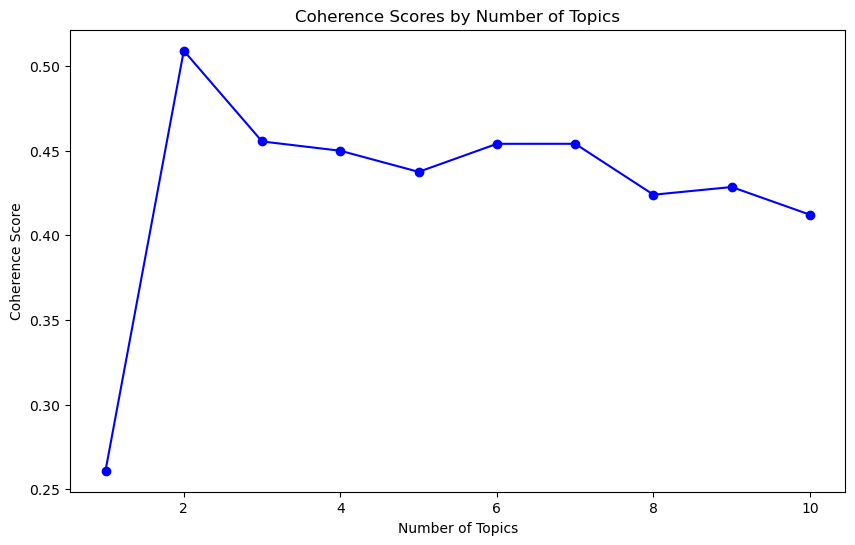

Best Number of Topics: 2 with Coherence Score: 0.508997908720741


In [5]:
name_coherence_scores_nmf_tfidf = compute_coherence_scores_nmf(processed_df['processed_name'], TfidfVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.70311630317845
Number of Topics: 2, Coherence Score: 0.6917909269881231
Number of Topics: 3, Coherence Score: 0.8012758355846685
Number of Topics: 4, Coherence Score: 0.8168170104684962
Number of Topics: 5, Coherence Score: 0.8520654182865751
Number of Topics: 6, Coherence Score: 0.8499683920459998
Number of Topics: 7, Coherence Score: 0.8467924334779111
Number of Topics: 8, Coherence Score: 0.8233333248940664
Number of Topics: 9, Coherence Score: 0.8102042151374004


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 10, Coherence Score: 0.8134687130236765


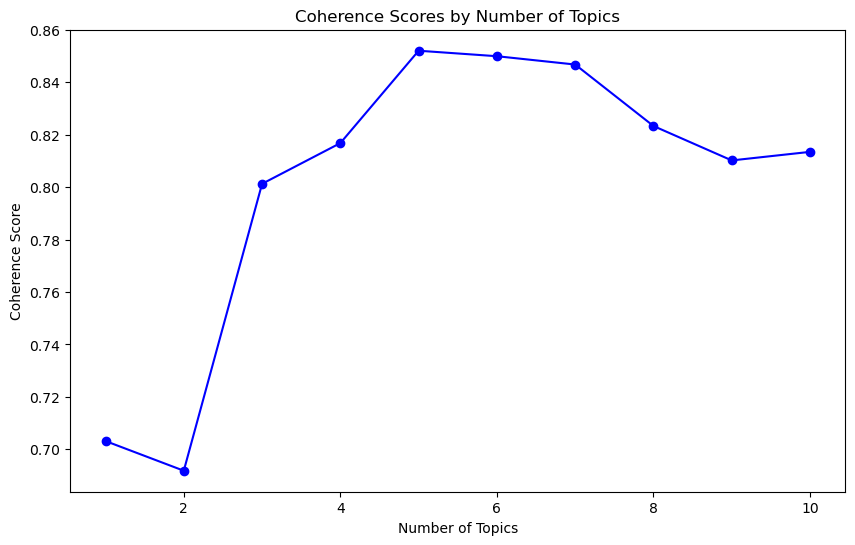

Best Number of Topics: 5 with Coherence Score: 0.8520654182865751


In [6]:
name_ingredients_coherence_scores_nmf_tfidf = compute_coherence_scores_nmf(processed_df['combined_name_ingredients'], TfidfVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.5544670970848786
Number of Topics: 2, Coherence Score: 0.5151069480608044
Number of Topics: 3, Coherence Score: 0.5440153490581888
Number of Topics: 4, Coherence Score: 0.5822950143975587
Number of Topics: 5, Coherence Score: 0.653113506874723
Number of Topics: 6, Coherence Score: 0.6649749350145515
Number of Topics: 7, Coherence Score: 0.6342253145101909
Number of Topics: 8, Coherence Score: 0.6347411739662148
Number of Topics: 9, Coherence Score: 0.6512016362435289
Number of Topics: 10, Coherence Score: 0.6607648415550059
Number of Topics: 11, Coherence Score: 0.6725459719060601
Number of Topics: 12, Coherence Score: 0.6741292074654263
Number of Topics: 13, Coherence Score: 0.673106329241797
Number of Topics: 14, Coherence Score: 0.6716346768065415


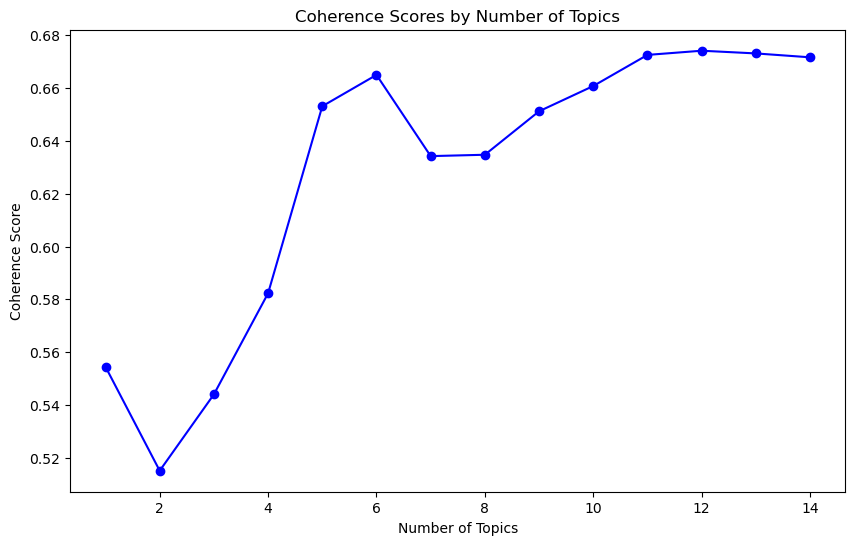

Best Number of Topics: 12 with Coherence Score: 0.6741292074654263


In [7]:
texts_coherence_scores_nmf_tfidf = compute_coherence_scores_nmf(processed_df['combined_texts'], TfidfVectorizer(), range(1, 15,1))

Number of Topics: 1, Coherence Score: 0.5588867306254145
Number of Topics: 2, Coherence Score: 0.5142095557552722
Number of Topics: 3, Coherence Score: 0.5251247275153705
Number of Topics: 4, Coherence Score: 0.6020806606542678
Number of Topics: 5, Coherence Score: 0.6490564384586424
Number of Topics: 6, Coherence Score: 0.6373202454641639
Number of Topics: 7, Coherence Score: 0.6158752913048102
Number of Topics: 8, Coherence Score: 0.6242406299623914
Number of Topics: 9, Coherence Score: 0.6568206758443907
Number of Topics: 10, Coherence Score: 0.6632246407915698
Number of Topics: 11, Coherence Score: 0.6794448626009832
Number of Topics: 12, Coherence Score: 0.6823300915299643
Number of Topics: 13, Coherence Score: 0.6745770683305273
Number of Topics: 14, Coherence Score: 0.6783406769255187


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 15, Coherence Score: 0.6699856285106003


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 16, Coherence Score: 0.6535136124115557
Number of Topics: 17, Coherence Score: 0.6528439241419037
Number of Topics: 18, Coherence Score: 0.6536059129794098
Number of Topics: 19, Coherence Score: 0.649490623010452


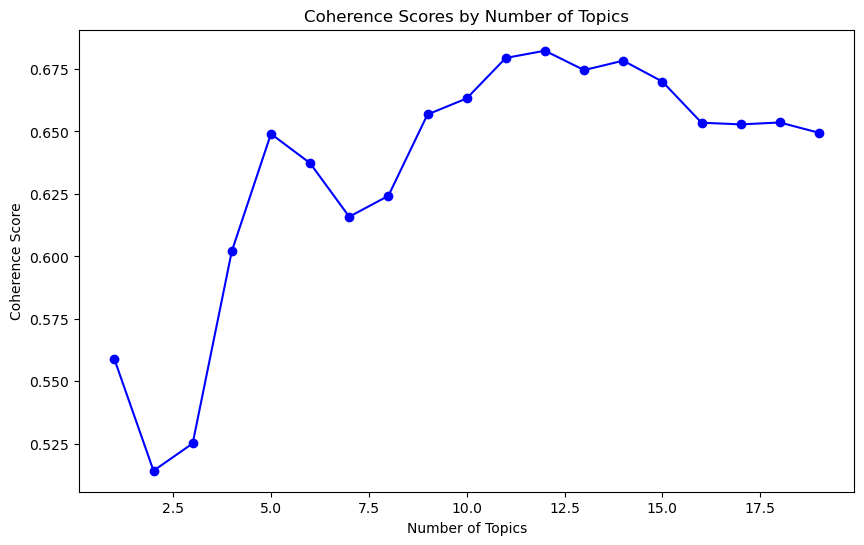

Best Number of Topics: 12 with Coherence Score: 0.6823300915299643


In [8]:
all_coherence_scores_nmf_tfidf = compute_coherence_scores_nmf(processed_df['combined_all'], TfidfVectorizer(), range(1, 20,1))

Compare the performance of NMF model on Count vectorizer using using "processed_name", "combined_name_ingredients", "combined_texts" and "combined_all" columns seperately

Number of Topics: 15, Coherence Score: 0.42716989487071105
Number of Topics: 16, Coherence Score: 0.42824871048041147
Number of Topics: 17, Coherence Score: 0.41125975052411745
Number of Topics: 18, Coherence Score: 0.4276752838734805
Number of Topics: 19, Coherence Score: 0.4279283536585171
Number of Topics: 20, Coherence Score: 0.41543479149802226
Number of Topics: 21, Coherence Score: 0.4088637089989335
Number of Topics: 22, Coherence Score: 0.40891445257122444
Number of Topics: 23, Coherence Score: 0.40542439885800596
Number of Topics: 24, Coherence Score: 0.40188386839043916
Number of Topics: 25, Coherence Score: 0.3962568588530124
Number of Topics: 26, Coherence Score: 0.39678382620490765
Number of Topics: 27, Coherence Score: 0.38893398983755506
Number of Topics: 28, Coherence Score: 0.38951716066180886
Number of Topics: 29, Coherence Score: 0.39175090732823376


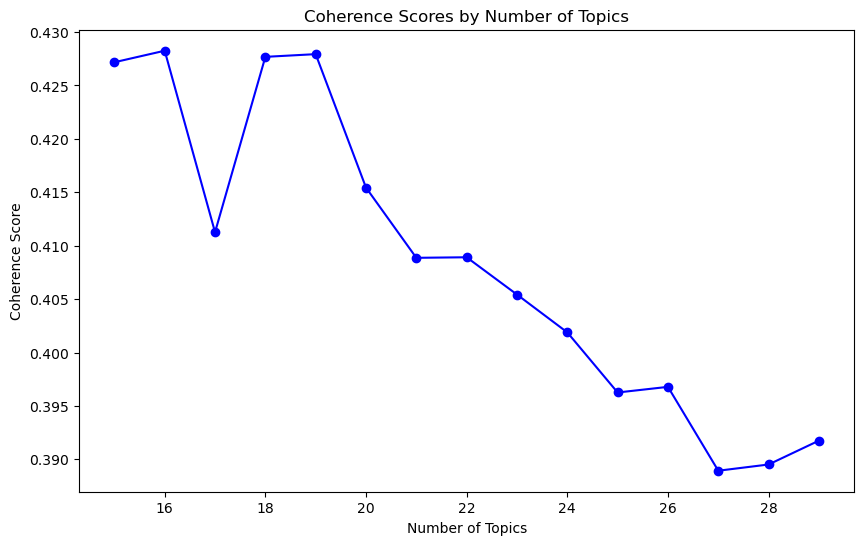

Best Number of Topics: 16 with Coherence Score: 0.42824871048041147


In [9]:
name_coherence_scores_nmf_countvect = compute_coherence_scores_nmf(processed_df['processed_name'],  CountVectorizer(), range(15, 30,1))

Number of Topics: 1, Coherence Score: 0.7229284187587682
Number of Topics: 2, Coherence Score: 0.759924773826341
Number of Topics: 3, Coherence Score: 0.7381507557812451
Number of Topics: 4, Coherence Score: 0.7258968417828586
Number of Topics: 5, Coherence Score: 0.7248473124717435
Number of Topics: 6, Coherence Score: 0.7668209088165532
Number of Topics: 7, Coherence Score: 0.7726281670182962
Number of Topics: 8, Coherence Score: 0.7567195519868128
Number of Topics: 9, Coherence Score: 0.7561294476512468
Number of Topics: 10, Coherence Score: 0.7325040681517095


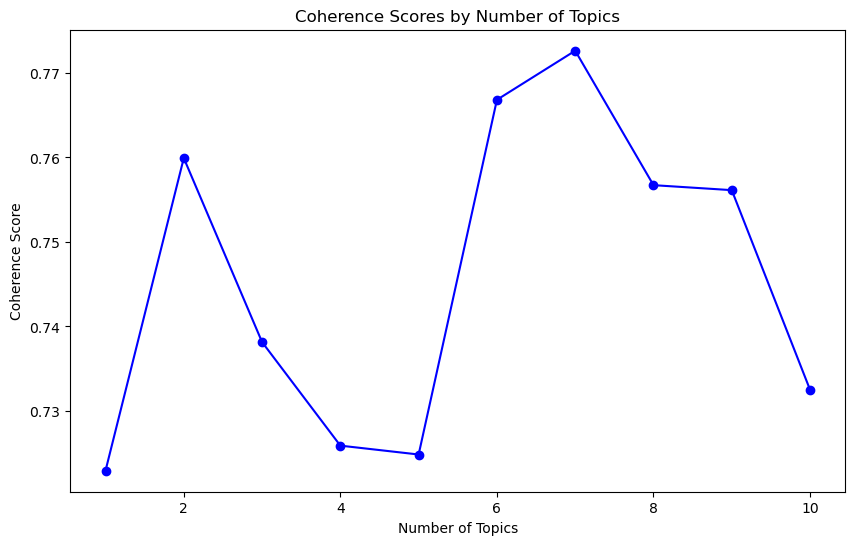

Best Number of Topics: 7 with Coherence Score: 0.7726281670182962


In [10]:
name_ingredients_coherence_scores_nmf_countvect = compute_coherence_scores_nmf(processed_df['combined_name_ingredients'],  CountVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.47917382802990083
Number of Topics: 2, Coherence Score: 0.4401447391261063
Number of Topics: 3, Coherence Score: 0.4569420674097411
Number of Topics: 4, Coherence Score: 0.5297664941082004
Number of Topics: 5, Coherence Score: 0.5239094750097004
Number of Topics: 6, Coherence Score: 0.5364606891444604
Number of Topics: 7, Coherence Score: 0.5154023465293752
Number of Topics: 8, Coherence Score: 0.5250058925407369
Number of Topics: 9, Coherence Score: 0.532699639252508
Number of Topics: 10, Coherence Score: 0.5302388550644895


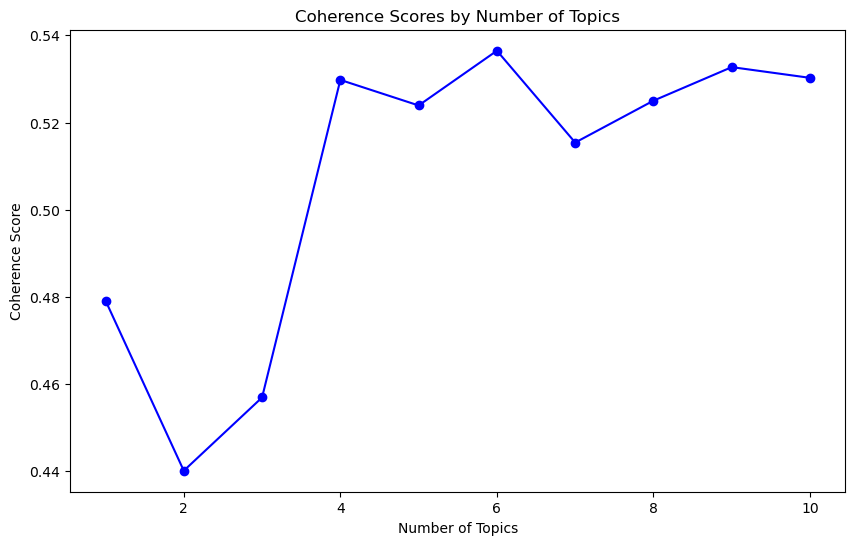

Best Number of Topics: 6 with Coherence Score: 0.5364606891444604


In [11]:
texts_coherence_scores_nmf_countvect = compute_coherence_scores_nmf(processed_df['combined_texts'],  CountVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.4912878514376281
Number of Topics: 2, Coherence Score: 0.44621593828785083
Number of Topics: 3, Coherence Score: 0.45914791895229734
Number of Topics: 4, Coherence Score: 0.5324146703326926
Number of Topics: 5, Coherence Score: 0.5249558282962439
Number of Topics: 6, Coherence Score: 0.5346154016557095
Number of Topics: 7, Coherence Score: 0.5223533280832025
Number of Topics: 8, Coherence Score: 0.5272506154973482
Number of Topics: 9, Coherence Score: 0.5348290243453167
Number of Topics: 10, Coherence Score: 0.5428840713146451
Number of Topics: 11, Coherence Score: 0.5578247507509949
Number of Topics: 12, Coherence Score: 0.5620001331788494
Number of Topics: 13, Coherence Score: 0.5621007860504148
Number of Topics: 14, Coherence Score: 0.5599232398687953


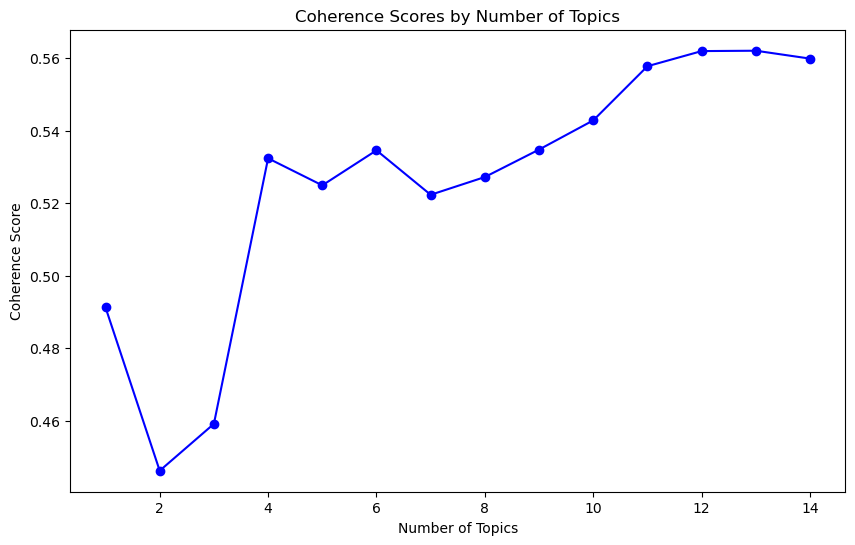

Best Number of Topics: 13 with Coherence Score: 0.5621007860504148


In [12]:
all_coherence_scores_nmf_countvect = compute_coherence_scores_nmf(processed_df['combined_all'],  CountVectorizer(), range(1, 15, 1))

Choose the best combination of data based on the highest coherence score of models

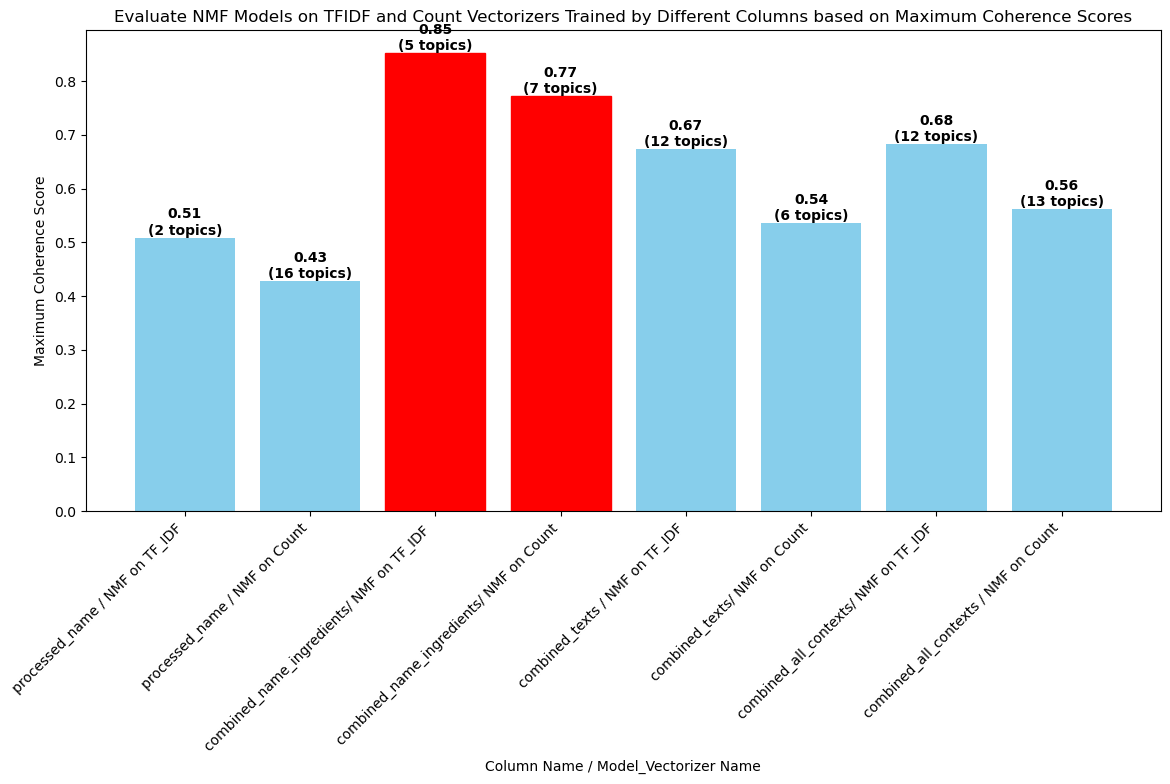

In [13]:
coherence_scores_dict = {"processed_name / NMF on TF_IDF": name_coherence_scores_nmf_tfidf[0],
    "processed_name / NMF on Count": name_coherence_scores_nmf_countvect[0],                 
    "combined_name_ingredients/ NMF on TF_IDF ": name_ingredients_coherence_scores_nmf_tfidf[0],
    "combined_name_ingredients/ NMF on Count": name_ingredients_coherence_scores_nmf_countvect[0],
    "combined_texts / NMF on TF_IDF": texts_coherence_scores_nmf_tfidf[0], 
    "combined_texts/ NMF on Count": texts_coherence_scores_nmf_countvect[0],
    "combined_all_contexts/ NMF on TF_IDF": all_coherence_scores_nmf_tfidf[0],     
     "combined_all_contexts / NMF on Count": all_coherence_scores_nmf_countvect[0]}

# Best topic numbers
best_num_topics = [name_coherence_scores_nmf_tfidf[1], name_coherence_scores_nmf_countvect[1],
                   name_ingredients_coherence_scores_nmf_tfidf[1], name_ingredients_coherence_scores_nmf_countvect[1],
                   texts_coherence_scores_nmf_tfidf[1], texts_coherence_scores_nmf_countvect[1],
                   all_coherence_scores_nmf_tfidf[1], all_coherence_scores_nmf_countvect[1]]

# Extract coherence scores and assign best topics
labels = list(coherence_scores_dict.keys())
max_scores = [max(scores) for scores in coherence_scores_dict.values()]
best_topics_for_each = [best_num_topics[i] for i in range(len(labels))]

# Get indices of the two highest scores
top_two_indices = sorted(range(len(max_scores)), key=lambda i: max_scores[i], reverse=True)[:2]

plt.figure(figsize=(12, 8))
bars = plt.bar(labels, max_scores, color='skyblue')

# Highlight the bars with the two highest coherence scores in red
for idx in top_two_indices:
    bars[idx].set_color('red')

# Annotate each bar with the coherence score and best topic count
for bar, score, topics in zip(bars, max_scores, best_topics_for_each):
    plt.text(bar.get_x() + bar.get_width() / 2, score, f'{score:.2f}\n({topics} topics)', 
             ha='center', va='bottom', fontweight='bold', color='black')

plt.xlabel("Column Name / Model_Vectorizer Name")
plt.ylabel("Maximum Coherence Score")
plt.title("Evaluate NMF Models on TFIDF and Count Vectorizers Trained by Different Columns based on Maximum Coherence Scores")

# Align x-ticks directly under bars
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.rc('font', family='Arial', size=12)

plt.tight_layout()
plt.show()

Train the best NMF model on TF-IDF with the optimal number of topics

In [14]:
best_num_topics = 6
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_df['combined_name_ingredients'])

# Train the NMF model with the optimal number of topics
nmf_model = NMF(n_components=best_num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)
topic_matrix = nmf_model.transform(tfidf_matrix)

# Sum the topic weights across all recipes for each topic
topic_distribution = np.sum(topic_matrix, axis=0)

# Get the feature names (vocabulary) from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum TF-IDF scores across all recipes
tfidf_scores = tfidf_matrix.sum(axis=0).A1  

# Create a dictionary of words and their TF-IDF scores
word_tfidf_dict = dict(zip(feature_names, tfidf_scores))

A- Display the top words for each topic in the best NMF model

In [15]:
num_top_words = 20  
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

Topic 1: powder coriander masala dhania chilli cumin jeera turmeric haldi garam red green ginger onion potato salt aloo garlic seeds oil
Topic 2: pepper olive bell capsicum virgin extra cheese green sauce garlic black onion oil corn salt red carrot pasta gajjar mushroom
Topic 3: dal split urad chana bengal moong gram white toor arhar rice asafoetida hing green yellow ghee chilli whole idli curry
Topic 4: flour sugar whole milk wheat maida butter purpose egg vanilla chocolate extract powder eggless water almond badam banana caster salt
Topic 5: cardamom elaichi cinnamon dalchini stick clove pod laung seed bay tej patta ghee rice leaf black nut peppercorn milk ginger
Topic 6: seed mustard curry kadugu coconut sprig dry chilli red tamarind asafoetida hing fresh oil methi sesame fenugreek seeds raw turmeric


B- Plot the topic distribution for the best NMF model

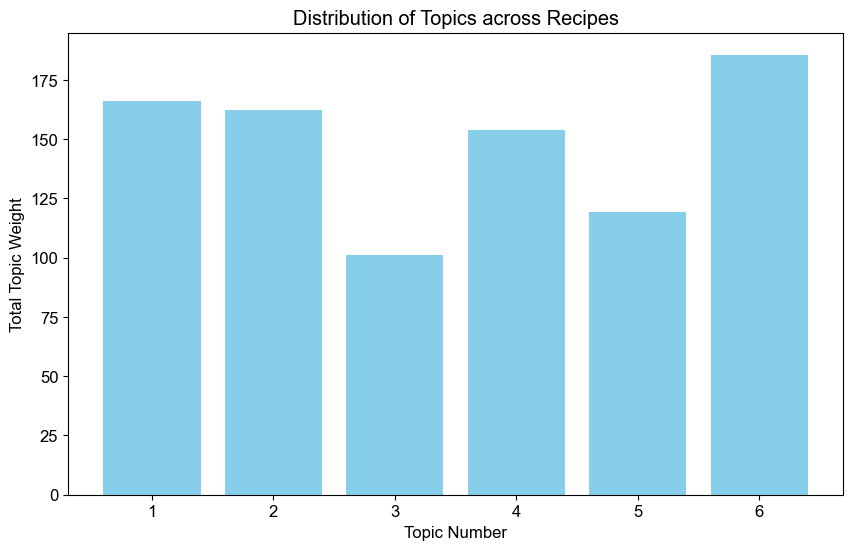

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, best_num_topics + 1), topic_distribution, color='skyblue')
plt.xlabel("Topic Number")
plt.ylabel("Total Topic Weight")
plt.title("Distribution of Topics across Recipes")
plt.xticks(range(1, best_num_topics + 1))  # Label each topic
plt.show()

C- Plot the word cloud for the best NMF model

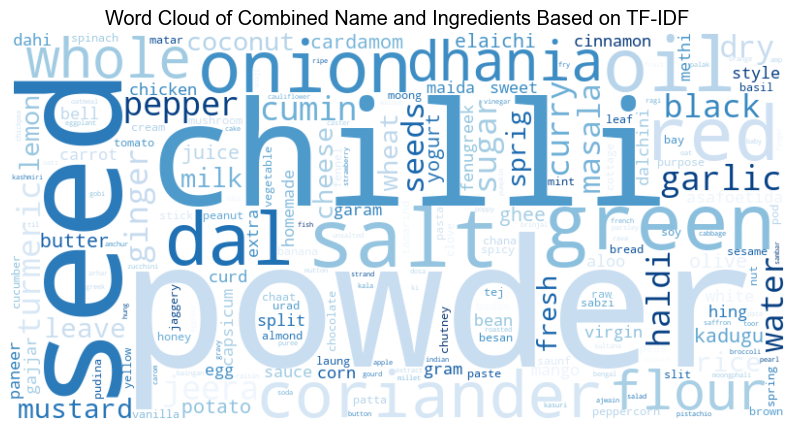

In [17]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues')
wordcloud.generate_from_frequencies(word_tfidf_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Combined Name and Ingredients Based on TF-IDF")
plt.show()

D- Plot 2D t-SNE for the topics of best model with words

In [18]:
topic_matrix.shape

(6471, 6)

In [19]:
topic_matrix.argmax(axis=1)

array([5, 0, 0, ..., 3, 2, 3], dtype=int64)

In [20]:
def plot_tsne_nmf_topics(nmf_model, tfidf_matrix, topic_matrix, feature_names, best_num_topics=6, perplexity=5):
   
    tsne_model = TSNE(n_components=2, perplexity=perplexity, init='pca', random_state=42)
    tsne_embedding = tsne_model.fit_transform(topic_matrix)

    # Create DataFrame for the t-SNE plot
    tsne_df = pd.DataFrame(tsne_embedding, columns=['x', 'y'])
    tsne_df['Topic'] = topic_matrix.argmax(axis=1)
    
    # Extract top words for each topic
    top_words_per_topic = []
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_word_indices = topic.argsort()  # Top 10 words by topic
        words = [feature_names[i] for i in top_word_indices]
        top_words_per_topic.append(words)
    
    # Assign each word a position in t-SNE space and its associated topic
    words_x, words_y, word_text, word_topics = [], [], [], []
    for topic_num, words in enumerate(top_words_per_topic):
        topic_points = tsne_embedding[tsne_df['Topic'] == topic_num]
        for i, word in enumerate(words):
            words_x.append(topic_points[i % len(topic_points)][0])  # Cycle through topic points
            words_y.append(topic_points[i % len(topic_points)][1])
            word_text.append(word)
            word_topics.append(topic_num + 1)

    # Plot interactive t-SNE with individual words
    fig = go.Figure()

    # Scatter plot for each word in each topic with hover text only
    fig.add_trace(go.Scatter(
        x=words_x,
        y=words_y,
        mode='markers',
        marker=dict(
            size=10, 
            color=word_topics, 
            colorscale='Blues', 
            colorbar=dict(title="Topic", tickvals=list(range(1, best_num_topics + 1)), ticktext=[f"Topic {i}" for i in range(1, best_num_topics + 1)]),
            showscale=True
        ),
        text=word_text,
        hoverinfo='text'
    ))

    # Calculate topic centers and add them to the plot
    topic_centers = np.array([tsne_embedding[tsne_df['Topic'] == i].mean(axis=0) for i in range(best_num_topics)])
    for i, (x, y) in enumerate(topic_centers):
        fig.add_trace(go.Scatter(
            x=[x],
            y=[y],
            mode='markers+text',
            marker=dict(size=15, symbol='x', color='red'),
            text=[f"Topic {i+1} Center"],
            textposition="top center",
            hoverinfo='text',
            name=f'Topic {i+1} Center',
            textfont=dict(color='red')  
        ))

    fig.update_layout(
        title=dict(
            text="2D t-SNE Plot of Topics with Words in NMF Model on TF-IDF",
            font=dict(family='Arial', size=16)  
        ),
        xaxis=dict(visible=False, scaleanchor="y", scaleratio=1),
        yaxis=dict(visible=False),
        width=800,
        height=800,
        showlegend=False,
        hovermode="closest"
    )

    # Add custom legend for topics 
    for i in range(1, best_num_topics + 1):
        fig.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=10, color=i, colorscale='Blues', colorbar=None),
            name=f'Topic {i}'
        ))
    
    fig.show()

In [21]:
# Plot the 2D t-SNE for NMF topics
plot_tsne_nmf_topics(nmf_model, tfidf_matrix, topic_matrix, feature_names)